In [101]:
# for the data and plotting
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# for the zooming
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from PIL import Image


In [73]:
df = pd.read_csv("plz_einwohner.csv", dtype={"plz": str})
df

,plz,note,einwohner,qkm,lat,lon
0,01067,01067 Dresden,11957,6.866862,51.06019,13.71117
1,01069,01069 Dresden,25491,5.351816,51.03964,13.73030
2,01097,01097 Dresden,14821,3.297752,51.06945,13.73781
3,01099,01099 Dresden,28018,58.506789,51.09272,13.82842
4,01108,01108 Dresden,5876,16.447222,51.15180,13.79227
...,...,...,...,...,...,...
8165,99988,99988 Südeichsfeld,4866,40.354020,51.17560,10.26567
8166,99991,99991 Unstrut-Hainich,5269,96.915369,51.12179,10.49575
8167,99994,99994 Schlotheim u.a.,6384,81.700264,51.23117,10.66455
8168,99996,99996 Menteroda,1995,21.635641,51.30519,10.57514


/tmp/ipykernel_2600/2300037929.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected["dichte"] = df_selected["einwohner"].div(df_selected["qkm"]).astype(int)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x7f3dba2ed760>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x7f3dba2edfa0>)

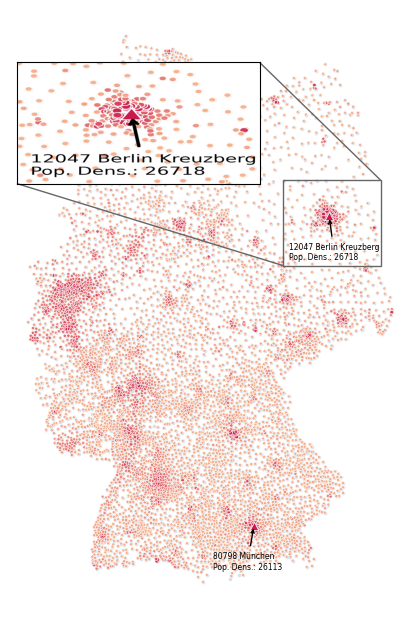

In [158]:
start_c = (0.96516917, 0.70776351, 0.5606593)
end_c = (0.7853517877739331, 0.1, 0.3)

fig = plt.figure(frameon=True)
fig.set_size_inches(4,6)
axes = plt.Axes(fig, [0, 0, 1, 1])
axes.set_axis_off()
fig.add_axes(axes)
sns.scatterplot(ax=axes, x=df['lon'], y=df['lat'], s=7, color='lightsteelblue', alpha=.5, marker='o')



# only plzs with more than 500 inhabitants
df_selected = df.loc[df["einwohner"]>500]

df_selected["dichte"] = df_selected["einwohner"].div(df_selected["qkm"]).astype(int)

r = np.linspace(start_c[0], end_c[0], num=len(df_selected["dichte"].unique()))
g = np.linspace(start_c[1], end_c[1], num=len(df_selected["dichte"].unique()))
b = np.linspace(start_c[2], end_c[2], num=len(df_selected["dichte"].unique()))

cust_palette = [item for item in zip(r,g,b)]

sns.scatterplot(ax=axes, x=df_selected['lon'], y=df_selected['lat'], size=abs(df_selected["dichte"]), alpha=1, marker='.', hue=abs(df_selected["dichte"]), palette=cust_palette, legend=False)

# select two highest density plzs
df_top = df_selected.sort_values("dichte", ascending=False).head(2)
sns.scatterplot(ax=axes, x=df_top['lon'], y=df_top['lat'], alpha=1, marker='^', c=end_c, legend=True)

# annotate the two highest density plzs
for i in range(len(df_top)):
    row = df_top.iloc[i]
    xy = (row.lon, row.lat)
    axes.annotate(f"{row.note}\nPop. Dens.: {row.dichte}", xy=xy, xytext=(xy[0]-1, xy[1]-.6), fontsize=5.5, arrowprops=dict(arrowstyle="->", facecolor='black'))

# now for the actual zooming
zoomed_x = [12.3, 14.7] # [10.3, 10.8]
zoomed_y = [51.8, 53]

x_range = list(axes.get_xlim())
y_range = list(axes.get_ylim())

fig.savefig(f"tmp.png", bbox_inches='tight', pad_inches=0, dpi=600)

img = Image.open(f"tmp.png")
img.load()
w, h = img.size

data = np.asarray(img, dtype="int32")
# data = data.reshape(fig.canvas.get_width_height() + (3,))
data = np.flip(data, axis=0)

x_dim = (x_range[1]-x_range[0]) * (fig.get_size_inches()[1]/fig.get_size_inches()[0])# (h/w)
y_dim = (y_range[1]-y_range[0]) * (fig.get_size_inches()[0]/fig.get_size_inches()[1])#(w/h)# (fig.get_size_inches()[0]/fig.get_size_inches()[1])

x_start = x_range[0]
y_start = y_range[0]

x_dim_new = len(data)  # somehow matplotlib doesn't save the figure in 1/1 resolution -- 6000*6126 -- therefore we have to take that into account here
y_dim_new = len(data[0])

x_factor = x_dim_new/x_dim
y_factor = y_dim_new/y_dim

x1 = zoomed_x[0]
x2 = zoomed_x[1]
y1 = zoomed_y[0]
y2 = zoomed_y[1]

y1_new = round((y1-y_start)*y_factor)
y2_new = round((y2-y_start)*y_factor)
x1_new = round((x1-x_start)*x_factor)
x2_new = round((x2-x_start)*x_factor)

extent = (x1, x2, y1, y2)

axins = zoomed_inset_axes(axes, 2.5, loc=2) # zoom = .5
# to hide axes from zoomed frame
axins.axes.xaxis.set_visible(False)
axins.axes.yaxis.set_visible(False)
axins.imshow(data[y1_new:y2_new, x1_new:x2_new, :], extent=extent,
                origin="lower")


mark_inset(axes, axins, loc1=1, loc2=3, fc="none", ec=".4")